In [1]:
import os
import numpy as np
import sklearn
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from scipy.linalg import svd

# Librosa for audio
import librosa
import librosa.display


# DISPLAY
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline
import IPython.display

import pdb

In [2]:
dataset_path = "/home/lblier/data/ESC-50/"
sampling = 44100
X = np.load("/home/lblier/preprocessed/input.npy")
y = np.load("/home/lblier/preprocessed/output.npy")

In [3]:
#feat = (lambda y: librosa.core.cqt(y,sr=sampling,real=False))
feat = (lambda y: librosa.feature.mfcc(y,sr=sampling))
p = 0

a = []
for i in range(X.shape[0]):
    a.append(feat(X[i]))
    if (i*10) % X.shape[0] == 0:
        print(str((i*10)//X.shape[0])+"0% computed")
del(X)
X_repr = np.stack(a, axis=0)
del(a)

00% computed
10% computed
20% computed
30% computed
40% computed
50% computed
60% computed
70% computed
80% computed
90% computed


In [4]:
X_train, X_test, y_train, y_test = \
    train_test_split(X_repr, y, test_size=0.25, 
                     random_state=42, stratify=y)
del(X_repr)

In [5]:
class PCA_complex():
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit(self, X):
        U, s, V = svd(X, full_matrices=False)
        del(U)
        self.P = V[:self.n_components,:]
        self.s = s
        self.explained_variance_ratio_ = s
        
    def fit_transform(self, X):
        k = self.n_components
        U, s, V = svd(X, full_matrices=False)
        self.P = V[:k,:]
        self.s = s
        self.explained_variance_ratio_ = s

        return np.abs(U[:,:k]*s[:k])
        
    def transform(self, X):
        return np.abs(np.dot(X, self.P.T))

In [11]:
class PCA_global():
    def __init__(self, L1, complex_values = False):
        self.L1 = L1
        self.complex_values = complex_values
        
        if complex_values:
            self.pca1 = PCA_complex(L1)
        else:
            self.pca1 = PCA(L1)
        
        #self.classifier = RandomForestClassifier()
        self.classifier = SVC(C=1.,kernel='linear')

    
    def fit(self, X, y):
        X_reshaped = np.reshape(X, (X.shape[0], -1))
        X_transformed = self.pca1.fit_transform(X_reshaped)
        self.classifier.fit(X_transformed, y)
    
    def predict(self, X):
        X_reshaped = np.reshape(X, (X.shape[0], -1))
        X_transformed = self.pca1.transform(X_reshaped)
        return self.classifier.predict(X_transformed)
        
    def score(self, X, y):
        X_reshaped = np.reshape(X, (X.shape[0], -1))
        X_transformed = self.pca1.transform(X_reshaped)
        return self.classifier.score(X_transformed, y)
        
    def plot_explained_variance_ratio(self):
        plt.plot(self.pca1.explained_variance_ratio_)

In [12]:
class PCA_local():
    def __init__(self, L1, complex_values=False):
        self.L1 = L1
        self.complex_values = complex_values
        if complex_values:
            self.pca1 = PCA_complex(L1)
        else:
            self.pca1 = PCA(n_components=L1)
            
        self.classifier = SVC(C=1.,kernel='linear')
        #self.classifier = RandomForestClassifier()

        
    def fit(self, X, y):
        # First put the data into the right shape
        n,q,t = X.shape
        X_reshaped = np.swapaxes(X, 0,1)
        X_reshaped = np.reshape(X_reshaped, 
                                (X_reshaped.shape[0],-1))
        X_reshaped = X_reshaped.T
        
        # Fit and transform it
        X_transformed = self.pca1.fit_transform(X_reshaped)
        
        # Reshape it
        X_transformed = X_transformed.T
        X_transformed = np.reshape(X_transformed, 
                                   (X_transformed.shape[0], n, t))
        X_transformed = np.swapaxes(X_transformed, 0,1)
        X_transformed = np.reshape(X_transformed, (n, -1))
        
        self.classifier.fit(X_transformed, y)
    
    def predict(self, X):
        # First put the data into the right shape
        n,q,t = X.shape
        X_reshaped = np.swapaxes(X, 0,1)
        X_reshaped = np.reshape(X_reshaped, 
                                (X_reshaped.shape[0],-1))
        X_reshaped = X_reshaped.T
        
        # Transform it
        X_transformed = self.pca1.transform(X_reshaped)
        
        # Reshape it
        X_transformed = X_transformed.T
        X_transformed = np.reshape(X_transformed, 
                                   (X_transformed.shape[0], n, t))
        X_transformed = np.swapaxes(X_transformed, 0,1)
        X_transformed = np.reshape(X_transformed, (n, -1))
        return self.classifier.predict(X_transformed)
        
    def score(self, X, y):
        # First put the data into the right shape
        n,q,t = X.shape
        X_reshaped = np.swapaxes(X, 0,1)
        X_reshaped = np.reshape(X_reshaped, 
                                (X_reshaped.shape[0],-1))
        X_reshaped = X_reshaped.T
        
        # Transform it
        X_transformed = self.pca1.transform(X_reshaped)

        # Reshape it
        X_transformed = X_transformed.T
        X_transformed = np.reshape(X_transformed, 
                                   (X_transformed.shape[0], n, t))
        X_transformed = np.swapaxes(X_transformed, 0,1)
        X_transformed = np.reshape(X_transformed, (n, -1))
        return self.classifier.score(X_transformed, y)
        
    def plot_explained_variance_ratio(self):
        plt.plot(self.pca1.explained_variance_ratio_)

In [27]:
L1 = 3
classifier = PCA_local(L1, complex_values=False)
classifier.fit(X_train, y_train)

In [28]:
score_train = classifier.score(X_train, y_train)
score_test = classifier.score(X_test, y_test)

In [29]:
score_train, score_test

(1.0, 0.29599999999999999)

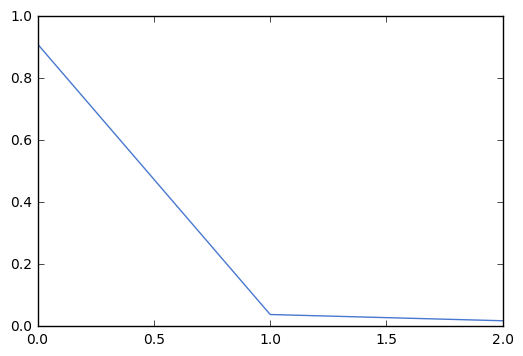

In [30]:
classifier.plot_explained_variance_ratio()